In [1]:
# Bring in (new) PNC cohort

import pickle
from pathlib import Path
import numpy as np

newdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC'
newdemo = pickle.load(open(f'{newdir}/demographics.pkl', 'rb'))

newfc = []
age = []
sex = []
race = []

for sub in newdemo['age_at_cnb']:
    for task in ['rest', 'nback', 'emoid']:
        f = f'{newdir}/fc/{sub}_task-{task}_fc.npy'
        if not Path(f).exists():
            continue
        if sub not in newdemo['Race'] or newdemo['Race'][sub] not in ['AA', 'EA']:
            continue
        p = np.load(f)
        a = newdemo['age_at_cnb'][sub]
        s = newdemo['Sex'][sub] == 'M'
        r = newdemo['Race'][sub] == 'AA'
        newfc.append(p)
        age.append(a)
        sex.append(s)
        race.append(r)
        
newfc = np.stack(newfc)
age = np.array(age)
sex = np.array(sex)
race = np.array(race)

print(age.shape)
print(np.mean(age))
print(np.mean(sex))
print(np.mean(race))
print(newfc.shape)

(3849,)
14.398285268901013
0.473629514159522
0.4811639386853728
(3849, 34716)


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LogisticRegression

class LowRankReg(nn.Module):
    def __init__(self):
        super(LowRankReg, self).__init__()
        dim = 1
        self.A = nn.Parameter((264*dim)**-0.5*torch.randn(dim,264,2).float().cuda())
        self.B = nn.Parameter((264*dim)**-0.5*torch.randn(dim,264,2).float().cuda())
        self.b = nn.Parameter(torch.randn(dim).float().cuda())
        
    def get_w(self):
        a,b = torch.triu_indices(264, 264, offset=1)
        wA = torch.einsum('dac,dbc->dab', self.A, self.A)
        wB = torch.einsum('dac,dbc->dab', self.B, self.B)
        return wA[:,a,b], wB[:,a,b]
    
    def to_imgs(self):
        IA = np.zeros((self.A.shape[0],264,264))
        IB = IA.copy()
        wA, wB = self.get_w()
        wA, wB = [w.detach().cpu().numpy() for w in [wA, wB]]
        a,b = np.triu_indices(264, 1)
        IA[:,a,b] = wA
        IA[:,b,a] = wA
        IB[:,a,b] = wB
        IB[:,b,a] = wB
        return IA, IB
    
    def to_sum_img(self):
        IA, IB = self.to_imgs()
        return np.sum(IA, axis=0), np.sum(IB, axis=0)
    
    def to_img(self, i):
        IA, IB = self.to_imgs()
        return IA[i], IB[i]
    
    def to_sig_imgs(self, x):
        wA, wB = self.get_w()
        sA = torch.einsum('aw,dw->w', x, wA)
        sB = torch.einsum('aw,dw->w', x, wB)
        a,b = np.triu_indices(264, 1)
        IA = np.zeros((self.A.shape[0],264,264))
        IB = IA.copy()
        IA[:,a,b] = sA
        IA[:b,a] = sA
        IB[a,b] = sB
        IB[b,a] = sB
        return IA, IB
    
    def forward(self, x):
        wA, wB = self.get_w()
        yA = torch.einsum('aw,dw->a', x, wA)
        yB = torch.einsum('aw,dw->a', x, wB)
        y = F.relu(yA)-F.relu(-yB)
        return y
    
def rmse(yhat, y):
    if isinstance(yhat, np.ndarray):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

def sigmoid(x):
    return 1/(1+torch.exp(-x))

def celoss(yhat, y):
    yhat = sigmoid(yhat)
    yhat = yhat - 1e-5*yhat/torch.abs(yhat)
    return -torch.sum(y*torch.log(yhat)+(1-y)*torch.log(1-yhat))/len(yhat)

idcs = np.random.permutation(newfc.shape[0])
idcs = idcs[:2000]
x = newfc[idcs]
y = age[idcs]

min_loss = 10
sav = None
savs = []

for _ in range(10):

    xtr, xt, ytr, yt = train_test_split(x, y, stratify=y, train_size=0.5)

    mu = np.mean(ytr)
    ytr -= mu
    yt -= mu
    
#     reg = Ridge(alpha=1).fit(xtr, ytr)
#     yhat = reg.predict(xt)
#     print(rmse(yhat, yt))

#     clf = LogisticRegression(C=100, max_iter=1000).fit(xtr, ytr)
#     yhat = clf.predict(xt)
#     print(np.mean(yhat == yt))
    
#     break

    xtr, xt, ytr, yt = [torch.from_numpy(a).float().cuda() for a in [xtr, xt, ytr, yt]]
    
    lrreg = LowRankReg()
    optim = torch.optim.Adam(lrreg.parameters(), lr=1e-3, weight_decay=1e-1)

    nepochs = 2000
    pperiod = 1000

    for e in range(nepochs):
        optim.zero_grad()
        yhat = lrreg(xtr)
        loss = rmse(yhat, ytr)
#         loss = celoss(yhat, ytr)
#         sloss = 0.01*lrreg.get_hloss()
#         sloss = 0.01*torch.sum(torch.abs(lrreg.A))
        loss.backward()
        optim.step()
        if e == nepochs-1 or e % pperiod == 0:
            print(f'{e} {float(loss)}')

    yhat = lrreg(xt)
#     acc = np.mean(((sigmoid(yhat) > 0.5) == yt).detach().cpu().numpy())
    acc = rmse(yhat, yt)
    null = rmse(0, yt)
    print(f'Test: {float(acc)} {float(null)}')
    print('---')
    
    savs.append(lrreg.to_imgs())
    
    if acc < min_loss:
        print('Saving')
        min_loss = float(acc)
        sav = lrreg

0 3.4683430194854736
1000 1.4046854972839355
1999 1.3712546825408936
Test: 2.571770429611206 3.4926209449768066
---
Saving
0 3.467691421508789
1000 1.479359745979309
1999 1.4172191619873047
Test: 2.5918359756469727 3.4926207065582275
---
0 3.492657423019409
1000 3.0251474380493164
1999 3.0232372283935547
Test: 3.2136945724487305 3.484410047531128
---
0 3.4910502433776855
1000 1.5026969909667969
1999 1.4148321151733398
Test: 2.5506997108459473 3.485960006713867
---
Saving
0 3.5498547554016113
1000 1.4536343812942505
1999 1.407043695449829
Test: 2.471233606338501 3.4838197231292725
---
Saving
0 3.5204081535339355
1000 1.414359211921692
1999 1.361743450164795
Test: 2.490171194076538 3.4864535331726074
---
0 3.482975482940674
1000 1.4089348316192627
1999 1.3642679452896118
Test: 2.5788862705230713 3.4897563457489014
---
0 3.4755332469940186
1000 1.5165313482284546
1999 1.4221001863479614
Test: 2.595456123352051 3.4897563457489014
---
0 3.4707281589508057
1000 1.4496605396270752
1999 1.3830

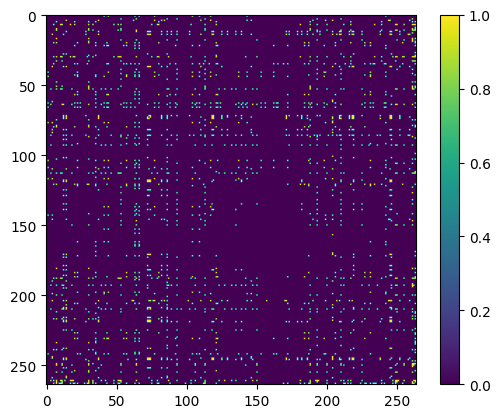

In [59]:
import matplotlib.pyplot as plt

# plt.imshow(remap(vec2mat(reg.coef_)))
# plt.imshow(remap(vec2mat(clf.coef_)))
# plt.imshow(remap(sav.to_sum_img()))
plt.imshow(remap(sav.to_sum_img()[0] > 0.05))
# plt.imshow(remap(savs[1][0][0]))
plt.colorbar()
plt.show()

In [11]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete
